In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
import os
import copy
import cmweather
import importlib

module_dir = os.path.expanduser('~/onedrive/code/research')
if module_dir not in sys.path:
    sys.path.insert(0, module_dir)

import cflib
importlib.reload(cflib)


<module 'cflib' from '/Users/java1127/onedrive/code/research/cflib.py'>

In [2]:
from scipy.interpolate import interp1d
import scipy.fft
import scipy.signal

def interpolate_2d_along_axis(data_in, axis=0):
    """
    Interpolate missing values (NaNs) in a 2D array along a specified axis.
    axis=0: vertical (columns)
    axis=1: horizontal (rows)
    """
    data = np.copy(data_in)
    
    if axis == 0:
        data = data.T
        
    x = np.arange(data.shape[1])
    for i in range(data.shape[0]):
        y = data[i, :]
        mask = np.isfinite(y)
        if np.any(mask):
            if len(x[mask]) > 1:
                interp_func = interp1d(x[mask], y[mask], bounds_error=False, fill_value=None)
                data[i, ~mask] = interp_func(x[~mask])
    
    if axis == 0:
        data = data.T
        
    # Fill remaining with percentile 1
    # Check if all nan
    if np.all(np.isnan(data)):
        return np.zeros_like(data)
        
    val = np.nanpercentile(data, 1)
    data[np.isnan(data)] = val
    return data

def get_transfer_function(n, kernel_type, width, **kwargs):
    """Generates 1D Transfer Function H[k]"""
    k = np.arange(n)
    # Avoid division by zero in analytical formulas for k=0
    
    if kernel_type == 'boxcar':
        # Analytical Boxcar: H = sin(W * pi * k / (2*n)) / (W * sin(pi * k / (2*n)))
        theta_half = (np.pi * k) / (2 * n)
        numerator = np.sin(width * theta_half)
        denominator = np.sin(theta_half)
        H = np.zeros(n)
        H[0] = 1.0
        mask = k > 0
        H[mask] = numerator[mask] / (denominator[mask] * width)
        return H
        
    elif kernel_type == 'gaussian':
        # Sigma from width approximation (W ~ sqrt(12)*sigma for similar variance)
        sigma = width / np.sqrt(12)
        omega_k = (np.pi * k) / n
        return np.exp(-0.5 * (omega_k * sigma)**2)
        
    elif kernel_type == 'savgol':
        # Discrete
        poly = kwargs.get('poly', 3)
        w_int = int(np.round(width))
        if w_int < poly + 2: w_int = poly + 2
        if w_int % 2 == 0: w_int += 1
        coeffs = scipy.signal.savgol_coeffs(w_int, poly)
        # DCT Transfer Function for Symmetric FIR: c[0] + 2*sum(c[i]*cos(i*w_k))
        w_k = np.pi * k / n
        mid = (len(coeffs) - 1) // 2
        H = np.ones(n) * coeffs[mid]
        for i in range(1, mid + 1):
            H += 2 * coeffs[mid + i] * np.cos(i * w_k)
        return H
        
    elif kernel_type == 'hanning':
        # Discrete
        w_int = int(np.round(width))
        if w_int < 3: w_int = 3
        if w_int % 2 == 0: w_int += 1
        window = scipy.signal.windows.hann(w_int)
        window /= np.sum(window)
        w_k = np.pi * k / n
        mid = (len(window) - 1) // 2
        H = np.ones(n) * window[mid]
        for i in range(1, mid + 1):
            H += 2 * window[mid + i] * np.cos(i * w_k)
        return H
    
    elif kernel_type == 'boxcar_discrete':
        # Discrete Boxcar - must match smooth_dynamic_kernel behavior
        # Width is rounded to nearest odd integer for symmetric kernel
        w_int = int(np.round(width))
        if w_int < 1: 
            w_int = 1
        if w_int % 2 == 0:  # Force odd window size
            w_int += 1
        
        # DCT Transfer Function for discrete boxcar
        # For odd window size w_int = 2*m + 1, the transfer function is:
        # H[k] = (1 + 2*sum_{j=1}^{m} cos(j*w_k)) / w_int
        w_k = np.pi * k / n
        H = np.ones(n)
        half_width = (w_int - 1) // 2
        for j in range(1, half_width + 1):
            H += 2 * np.cos(j * w_k)
        H /= w_int
        return H
    
    else:
        raise ValueError(f"Unknown kernel type: {kernel_type}")

def compute_polar_transfer_functions(data_shape, az_res_deg, width_pixels, kernel_type='boxcar', **kwargs):
    """
    Computes transfer functions for polar coordinate smoothing.
    
    Parameters:
    -----------
    data_shape : tuple
        Shape of data array (n_az, n_range) where axis 0 is azimuth/time, axis 1 is range
    az_res_deg : float
        Angular resolution in degrees
    width_pixels : float
        Smoothing width in pixels (physical width to maintain across range)
    kernel_type : str
        Type of smoothing kernel ('boxcar', 'gaussian', 'savgol', 'hanning')
    **kwargs : dict
        Additional parameters for specific kernels (e.g., poly for savgol)
    
    Returns:
    --------
    H_az : ndarray (n_az, n_range)
        Azimuth transfer function (varies with range to maintain constant physical width)
    H_range : ndarray (n_range,)
        Range transfer function (fixed)
    """
    n_az, n_range = data_shape
    
    # Azimuth resolution in radians
    az_res_rad = np.deg2rad(az_res_deg)
    
    # 1. Azimuth Transfer Function (varies with range to maintain constant physical width)
    H_az = np.zeros((n_range, n_az))  # Initially (n_range, n_az) for computation
    
    for i in range(n_range):
        # Range index (pixel position)
        r_idx = i + 1
        # Convert physical width to beams: arc_length = r * theta
        # For pixel i, the physical scale is proportional to r_idx
        # w_beams = width_pixels * (1.0 / r_idx) / az_res_rad
        w_beams = width_pixels / (r_idx * az_res_rad)
        # w_beams = max(w_beams, 1.0)  # Minimum 1 beam
        
        H_az[i, :] = get_transfer_function(n_az, kernel_type, w_beams, **kwargs)
    
    # Transpose to match data orientation (n_az, n_range)
    H_az = H_az.T
    
    # 2. Range Transfer Function (fixed width in pixels)
    H_range = get_transfer_function(n_range, kernel_type, width_pixels, **kwargs)
    
    return H_az, H_range

def apply_polar_dct_smoothing(data, az_res_deg, width_pixels, kernel_type='boxcar', **kwargs):
    """
    Apply DCT-based smoothing to polar coordinate data.
    
    Parameters:
    -----------
    data : ndarray (n_az, n_range)
        Input data where axis 0 is azimuth/time dimension, axis 1 is range dimension
    az_res_deg : float
        Angular resolution in degrees
    width_pixels : float
        Smoothing width in pixels
    kernel_type : str
        Type of smoothing kernel ('boxcar', 'gaussian', 'savgol', 'hanning')
    **kwargs : dict
        Additional parameters for specific kernels
    
    Returns:
    --------
    smoothed : ndarray
        Smoothed data with same shape as input, NaNs preserved
    """
    # Get transfer functions
    H_az, H_range = compute_polar_transfer_functions(
        data.shape, az_res_deg, width_pixels, kernel_type, **kwargs
    )
    
    # Create NaN mask
    mask = np.isnan(data)
    
    # Fill NaNs (interpolate along range first, then azimuth)
    data_filled = interpolate_2d_along_axis(data, axis=1)
    # data_filled = interpolate_2d_along_axis(data_filled, axis=0)
    
    # Apply azimuth smoothing (axis 0)
    X_az = scipy.fft.dct(data_filled, axis=0, type=2, norm='ortho')
    Y_az = X_az * H_az
    y_az = scipy.fft.idct(Y_az, axis=0, type=2, norm='ortho')
    
    # Apply range smoothing (axis 1)
    H_range_b = H_range[np.newaxis, :]  # Broadcast to (1, n_range)
    X_range = scipy.fft.dct(y_az, axis=1, type=2, norm='ortho')
    Y_range = X_range * H_range_b
    y_result = scipy.fft.idct(Y_range, axis=1, type=2, norm='ortho')
    
    # Restore NaNs
    y_result[mask] = np.nan
    
    return y_result



In [3]:
abs_path315 = '~/onedrive/code/research/smoothing/cfrad.20220223_022853.197_to_20220223_022905.383_COW1high_RHI.nc'
radar1 = xr.open_dataset(abs_path315)
field = 'DBZHCC_F'
radar1['DBZHCC_boxcar5'] = radar1[field] 

# Get data
raw_data = radar1[field].values  # Shape: (n_time/az, n_range)

# Define angular resolution (you need to set this based on your radar)
ang_res_deg = 0.2  # Example: 1 degree azimuth resolution

# Apply smoothing with simple pixel width
width_pixels = 5  # Smooth over 5 pixels
smoothed_data = apply_polar_dct_smoothing(raw_data, ang_res_deg, width_pixels, kernel_type='boxcar')
radar1['DBZHCC_boxcar5'].values = smoothed_data

In [4]:
# Create noise-free ground truth synthetic field IN CARTESIAN COORDINATES
# Then transform to radar polar coordinates

# Get radar geometry
n_az, n_range = raw_data.shape
ranges_m = radar1['range'].values
azimuths_deg = np.linspace(0, 360, n_az, endpoint=False)

# Create Cartesian grid from polar coordinates
# For each polar coordinate, compute (x, y)
az_rad = np.deg2rad(azimuths_deg)
AZ_rad, RG_m = np.meshgrid(az_rad, azimuths_deg, indexing='ij')
RG_m = np.meshgrid(az_rad, ranges_m, indexing='ij')[1]
AZ_rad = np.meshgrid(az_rad, ranges_m, indexing='ij')[0]

# Convert to Cartesian (assuming flat earth for simplicity)
X_cart = RG_m * np.sin(AZ_rad) / 1000.0  # km, East
Y_cart = RG_m * np.cos(AZ_rad) / 1000.0  # km, North

# Create smooth patterns in CARTESIAN space
# This ensures no singularity artifacts near radar
ground_truth = (
    25.0 +  # Base value
    8.0 * np.sin(2 * np.pi * X_cart / 40.0) +  # East-West wave (40 km wavelength)
    6.0 * np.cos(2 * np.pi * Y_cart / 30.0) +  # North-South wave (30 km wavelength)
    4.0 * np.exp(-((X_cart - 20)**2 + (Y_cart - 15)**2) / 200.0) +  # Gaussian feature at (20, 15) km
    3.0 * np.sin(np.sqrt(X_cart**2 + Y_cart**2) / 5.0)  # Radial pattern (smooth everywhere)
)

# Noisy version: Add realistic noise
np.random.seed(42)  # For reproducibility
noisy_field = ground_truth + np.random.normal(0, 2.0, (n_az, n_range))

# Add to dataset
radar1['ground_truth'] = radar1[field].copy()
radar1['ground_truth'].values = ground_truth

radar1['noisy_test'] = radar1[field].copy()
radar1['noisy_test'].values = noisy_field

print(f"Ground truth shape: {ground_truth.shape}")
print(f"Ground truth range: [{np.min(ground_truth):.2f}, {np.max(ground_truth):.2f}]")
print(f"Noisy field range: [{np.min(noisy_field):.2f}, {np.max(noisy_field):.2f}]")
print(f"Added noise std: {np.std(noisy_field - ground_truth):.2f}")

# Verify no singularity artifacts near radar (first few range bins)
near_radar = ground_truth[:, :5]  # First 5 range bins
print(f"\nNear-radar statistics (first 5 range bins):")
print(f"  Mean across azimuths at range 0: {np.mean(ground_truth[:, 0]):.4f} ± {np.std(ground_truth[:, 0]):.4f}")
print(f"  Mean across azimuths at range 1: {np.mean(ground_truth[:, 1]):.4f} ± {np.std(ground_truth[:, 1]):.4f}")
print(f"  (Lower std = less singularity artifact)")

Ground truth shape: (474, 1180)
Ground truth range: [8.04, 42.59]
Noisy field range: [1.72, 51.63]
Added noise std: 2.00

Near-radar statistics (first 5 range bins):
  Mean across azimuths at range 0: 31.2322 ± 0.0868
  Mean across azimuths at range 1: 31.2758 ± 0.1553
  (Lower std = less singularity artifact)


In [5]:
width_pixels = 15  # Smoothing width
# Apply both smoothing methods to noisy data
noisy_data = radar1['noisy_test'].values.copy()

# DCT boxcar discrete
radar1['noisy_dct'] = radar1['noisy_test'].copy()
smoothed_noisy_dct = apply_polar_dct_smoothing(noisy_data, ang_res_deg, width_pixels, kernel_type='boxcar_discrete')
radar1['noisy_dct'].values = smoothed_noisy_dct

# Dynamic kernel
radar1['noisy_dk'] = radar1['noisy_test'].copy()
smoothed_noisy_dk = cflib.smooth_dynamic_kernel(noisy_data, w=ang_res_deg, k=width_pixels)
radar1['noisy_dk'].values = smoothed_noisy_dk

# Compute errors relative to ground truth
error_dct = smoothed_noisy_dct - ground_truth
error_dk = smoothed_noisy_dk - ground_truth
error_noisy = noisy_field - ground_truth

radar1['error_dct'] = radar1['noisy_test'].copy()
radar1['error_dct'].values = error_dct

radar1['error_dk'] = radar1['noisy_test'].copy()
radar1['error_dk'].values = error_dk

# Compute metrics
rmse_noisy = np.sqrt(np.mean(error_noisy**2))
rmse_dct = np.sqrt(np.mean(error_dct**2))
rmse_dk = np.sqrt(np.mean(error_dk**2))

mae_noisy = np.mean(np.abs(error_noisy))
mae_dct = np.mean(np.abs(error_dct))
mae_dk = np.mean(np.abs(error_dk))

print("Performance vs Ground Truth:")
print("=" * 60)
print(f"{'Method':<20} {'RMSE':<12} {'MAE':<12} {'Improvement':<15}")
print("-" * 60)
print(f"{'Noisy (no smooth)':<20} {rmse_noisy:<12.4f} {mae_noisy:<12.4f} {'baseline':<15}")
print(f"{'DCT Boxcar':<20} {rmse_dct:<12.4f} {mae_dct:<12.4f} {(rmse_noisy-rmse_dct)/rmse_noisy*100:>6.2f}%")
print(f"{'Dynamic Kernel':<20} {rmse_dk:<12.4f} {mae_dk:<12.4f} {(rmse_noisy-rmse_dk)/rmse_noisy*100:>6.2f}%")
print()
print(f"Difference between methods:")
print(f"  RMSE difference: {abs(rmse_dct - rmse_dk):.6f} ({abs(rmse_dct - rmse_dk)/rmse_dk*100:.3f}%)")
print(f"  MAE difference:  {abs(mae_dct - mae_dk):.6f} ({abs(mae_dct - mae_dk)/mae_dk*100:.3f}%)")

Performance vs Ground Truth:
Method               RMSE         MAE          Improvement    
------------------------------------------------------------
Noisy (no smooth)    2.0016       1.5974       baseline       
DCT Boxcar           0.2625       0.1991        86.88%
Dynamic Kernel       0.2409       0.1897        87.97%

Difference between methods:
  RMSE difference: 0.021657 (8.991%)
  MAE difference:  0.009330 (4.917%)


/Users/java1127/onedrive/code/research/cflib.py:849: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if 'sweep' in rhi_dataset.dims and rhi_dataset.dims['sweep'] > 1:
/Users/java1127/onedrive/code/research/cflib.py:886: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(ground_range, total_height, data,


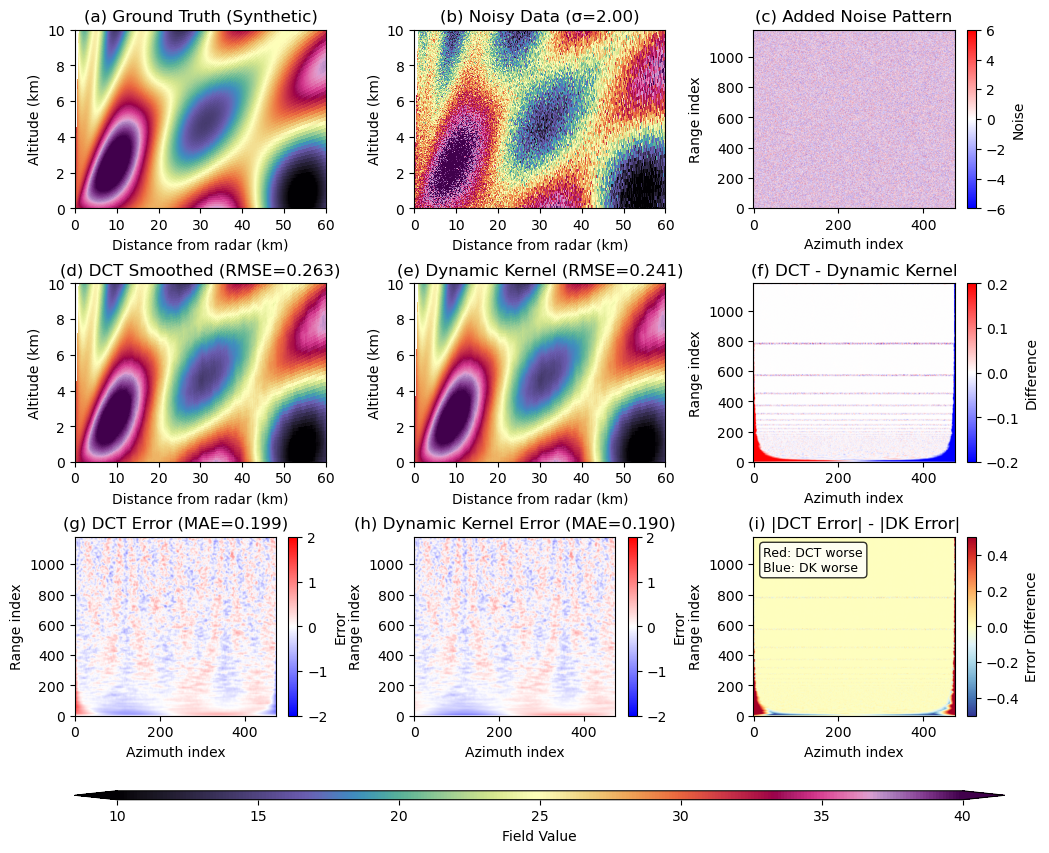

In [ ]:
# THIS IS FIGURE 2 IN THE PAPER
# Comprehensive visualization of ground truth comparison
# fig = plt.figure(figsize=(16, 12))
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 0.05], hspace=0.55, wspace=0.35)

# Create axes
axes = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(3)]

# Row 1: Ground truth, noisy, and noise pattern
plt.sca(axes[0][0])
cflib.plot_rhi(radar1, 'ground_truth', sweep=0, cmap='ChaseSpectral', vmax=40, vmin=10, 
               ax=axes[0][0], rasterized=True)
plt.xlim(0, 60)
plt.ylim(0, 10)
plt.title('(a) Ground Truth (Synthetic)')

plt.sca(axes[0][1])
cflib.plot_rhi(radar1, 'noisy_test', sweep=0, cmap='ChaseSpectral', vmax=40, vmin=10, 
               ax=axes[0][1], rasterized=True)
plt.xlim(0, 60)
plt.ylim(0, 10)
plt.title(f'(b) Noisy Data (σ={np.std(error_noisy):.2f})')

# Noise pattern
noise_pattern = noisy_field - ground_truth
im_noise = axes[0][2].imshow(noise_pattern.T, aspect='auto', cmap='bwr', 
                             vmin=-6, vmax=6, origin='lower', rasterized=True)
axes[0][2].set_xlabel('Azimuth index')
axes[0][2].set_ylabel('Range index')
axes[0][2].set_title('(c) Added Noise Pattern')
plt.colorbar(im_noise, ax=axes[0][2], label='Noise')

# Row 2: Smoothed results
plt.sca(axes[1][0])
cflib.plot_rhi(radar1, 'noisy_dct', sweep=0, cmap='ChaseSpectral', vmax=40, vmin=10, 
               ax=axes[1][0], rasterized=True)
plt.xlim(0, 60)
plt.ylim(0, 10)
plt.title(f'(d) DCT Smoothed (RMSE={rmse_dct:.3f})')

plt.sca(axes[1][1])
cflib.plot_rhi(radar1, 'noisy_dk', sweep=0, cmap='ChaseSpectral', vmax=40, vmin=10, 
               ax=axes[1][1], rasterized=True)
plt.xlim(0, 60)
plt.ylim(0, 10)
plt.title(f'(e) Dynamic Kernel (RMSE={rmse_dk:.3f})')

# Method difference
method_diff = smoothed_noisy_dct - smoothed_noisy_dk
im_diff = axes[1][2].imshow(method_diff.T, aspect='auto', cmap='bwr', 
                            vmin=-0.2, vmax=0.2, origin='lower', rasterized=True)
axes[1][2].set_xlabel('Azimuth index')
axes[1][2].set_ylabel('Range index')
axes[1][2].set_title('(f) DCT - Dynamic Kernel')
plt.colorbar(im_diff, ax=axes[1][2], label='Difference')

# Row 3: Error maps relative to ground truth
im_err_dct = axes[2][0].imshow(error_dct.T, aspect='auto', cmap='bwr', 
                                vmin=-2, vmax=2, origin='lower', rasterized=True)
axes[2][0].set_xlabel('Azimuth index')
axes[2][0].set_ylabel('Range index')
axes[2][0].set_title(f'(g) DCT Error (MAE={mae_dct:.3f})')
plt.colorbar(im_err_dct, ax=axes[2][0], label='Error')

im_err_dk = axes[2][1].imshow(error_dk.T, aspect='auto', cmap='bwr', 
                               vmin=-2, vmax=2, origin='lower', rasterized=True)
axes[2][1].set_xlabel('Azimuth index')
axes[2][1].set_ylabel('Range index')
axes[2][1].set_title(f'(h) Dynamic Kernel Error (MAE={mae_dk:.3f})')
plt.colorbar(im_err_dk, ax=axes[2][1], label='Error')

# Error difference
error_diff = np.abs(error_dct) - np.abs(error_dk)
im_err_diff = axes[2][2].imshow(error_diff.T, aspect='auto', cmap='RdYlBu_r', 
                                 vmin=-0.5, vmax=0.5, origin='lower', rasterized=True)
axes[2][2].set_xlabel('Azimuth index')
axes[2][2].set_ylabel('Range index')
axes[2][2].set_title('(i) |DCT Error| - |DK Error|')
axes[2][2].text(0.05, 0.95, 'Red: DCT worse\nBlue: DK worse', 
                transform=axes[2][2].transAxes, fontsize=9,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.colorbar(im_err_diff, ax=axes[2][2], label='Error Difference')

# Add main colorbar at bottom
cbar_ax = fig.add_subplot(gs[3, :])
mappable = axes[0][0].collections[0] if axes[0][0].collections else axes[0][0].images[0]
fig.colorbar(mappable, cax=cbar_ax, orientation='horizontal', label='Field Value', extend='both')
# plt.savefig('/Users/java1127/Library/CloudStorage/OneDrive-UCB-O365/code/research/smoothing/plots/synthetic_ground_truth_comparison.pdf', bbox_inches='tight')
plt.show()

In [8]:
radar1['DBZHCC_DK5'] = radar1[field] 
smoothed_data = cflib.smooth_dynamic_kernel(raw_data, w=0.2, k=5)
radar1['DBZHCC_DK5'].values = smoothed_data
radar1['DBZHCC_diff5'] = radar1[field] 
radar1['DBZHCC_diff5'].values = radar1['DBZHCC_boxcar5'].values - radar1['DBZHCC_DK5'].values
# report mean difference and standard error
diff = radar1['DBZHCC_diff5'].values
mean_diff = np.nanmean(diff)
std_err = np.nanstd(diff) / np.sqrt(np.count_nonzero(~np.isnan(diff)))
print(f"Mean difference: {mean_diff:.4f}, Standard error: {std_err:.4f}")

/Users/java1127/onedrive/code/research/cflib.py:386: RuntimeWarning: Mean of empty slice
  smoothed_data[j, i] = np.nanmean(data_noise[azimuth_indices[:, None], range_indices])


Mean difference: -0.0180, Standard error: 0.0019


/Users/java1127/onedrive/code/research/cflib.py:849: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if 'sweep' in rhi_dataset.dims and rhi_dataset.dims['sweep'] > 1:
/Users/java1127/onedrive/code/research/cflib.py:886: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = ax.pcolormesh(ground_range, total_height, data,


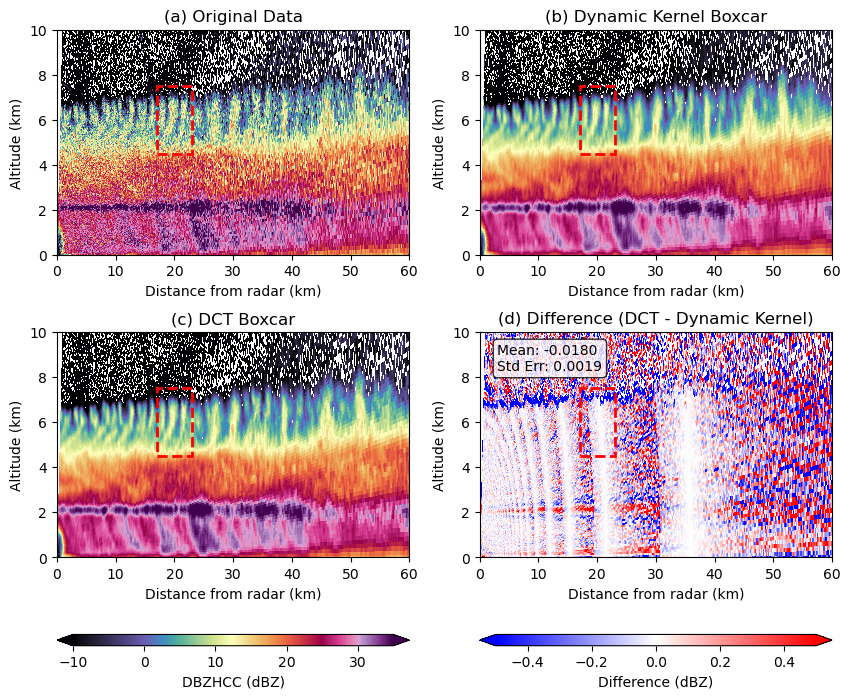

In [ ]:
# THIS IS FIGURE 3 IN THE PAPER
from matplotlib.patches import Rectangle

# Define zoom region limits for easy modification
zoom_xlim = [17, 23]  # Distance from radar (km)
zoom_ylim = [4.5, 7.5]    # Altitude (km)

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.05], hspace=0.5, wspace=0.2)

# Create axes for plots
axes = [[fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])],
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]]

# Original data
plt.sca(axes[0][0])
im0 = cflib.plot_rhi(radar1, 'DBZHCC_F', sweep=0, cmap='ChaseSpectral', vmax=35, vmin=-10, ax=axes[0][0], rasterized=True)
plt.xlim(0, 60)
plt.ylim(0, 10)
plt.title('(a) Original Data')
# Add zoom box
rect = Rectangle((zoom_xlim[0], zoom_ylim[0]), zoom_xlim[1]-zoom_xlim[0], zoom_ylim[1]-zoom_ylim[0], 
                 linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
axes[0][0].add_patch(rect)

# Dynamic Kernel Boxcar
plt.sca(axes[0][1])
im1 = cflib.plot_rhi(radar1, 'DBZHCC_DK5', sweep=0, cmap='ChaseSpectral', vmax=35, vmin=-10, ax=axes[0][1], rasterized=True)
plt.xlim(0, 60)
plt.ylim(0, 10)
plt.title('(b) Dynamic Kernel Boxcar')
rect = Rectangle((zoom_xlim[0], zoom_ylim[0]), zoom_xlim[1]-zoom_xlim[0], zoom_ylim[1]-zoom_ylim[0], 
                 linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
axes[0][1].add_patch(rect)

# DCT Boxcar
plt.sca(axes[1][0])
im2 = cflib.plot_rhi(radar1, 'DBZHCC_boxcar5', sweep=0, cmap='ChaseSpectral', vmax=35, vmin=-10, ax=axes[1][0], rasterized=True)
plt.xlim(0, 60)
plt.ylim(0, 10)
plt.title('(c) DCT Boxcar')
rect = Rectangle((zoom_xlim[0], zoom_ylim[0]), zoom_xlim[1]-zoom_xlim[0], zoom_ylim[1]-zoom_ylim[0], 
                 linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
axes[1][0].add_patch(rect)

# Difference
plt.sca(axes[1][1])
im3 = cflib.plot_rhi(radar1, 'DBZHCC_diff5', sweep=0, cmap='bwr', vmax=0.5, vmin=-0.5, ax=axes[1][1], rasterized=True)
plt.xlim(0, 60)
plt.ylim(0, 10)
plt.title('(d) Difference (DCT - Dynamic Kernel)')
rect = Rectangle((zoom_xlim[0], zoom_ylim[0]), zoom_xlim[1]-zoom_xlim[0], zoom_ylim[1]-zoom_ylim[0], 
                 linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
axes[1][1].add_patch(rect)
axes[1][1].text(0.05, 0.95, f'Mean: {mean_diff:.4f}\nStd Err: {std_err:.4f}', 
        transform=axes[1][1].transAxes, fontsize=10, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# # Add colorbars at bottom
cbar_ax1 = fig.add_subplot(gs[2, 0])
cbar_ax2 = fig.add_subplot(gs[2, 1])
# Get mappable objects from axes
mappable0 = axes[0][0].collections[0] if axes[0][0].collections else axes[0][0].images[0]
mappable3 = axes[1][1].collections[0] if axes[1][1].collections else axes[1][1].images[0]
fig.colorbar(mappable0, cax=cbar_ax1, orientation='horizontal', label='DBZHCC (dBZ)', extend='both')
fig.colorbar(mappable3, cax=cbar_ax2, orientation='horizontal', label='Difference (dBZ)', extend='both')
# plt.savefig('/Users/java1127/Library/CloudStorage/OneDrive-UCB-O365/code/research/smoothing/plots/COWdata_smoothing_comparison.pdf', bbox_inches='tight')
plt.show()

## Performance Benchmarking

Compare computational efficiency of DCT-based smoothing versus spatial convolution (Dynamic Kernel) method across different data sizes and window sizes.

In [ ]:
import time
import gc

kernel_labels = {
    'boxcar_discrete': 'Discrete Boxcar',
    'boxcar': 'Analytical Boxcar',
    'gaussian': 'Gaussian',
    'savgol': 'Savitzky-Golay',
    'hanning': 'Hanning'
}

def benchmark_smoothing(data, ang_res_deg, width_pixels, n_runs=5, warmup=1):
    """
    Benchmark all smoothing methods on the same data.
    
    Returns dict with timing results for each method.
    """
    results = {}
    
    # Benchmark all DCT kernel types
    for kernel_type in kernel_labels.keys():
        # Warmup
        for _ in range(warmup):
            _ = apply_polar_dct_smoothing(data, ang_res_deg, width_pixels, kernel_type=kernel_type)
        
        # Timed runs
        times = []
        for _ in range(n_runs):
            gc.collect()
            start = time.perf_counter()
            _ = apply_polar_dct_smoothing(data, ang_res_deg, width_pixels, kernel_type=kernel_type)
            end = time.perf_counter()
            times.append(end - start)
        
        results[f'dct_{kernel_type}'] = {
            'mean': np.mean(times),
            'std': np.std(times),
            'min': np.min(times),
            'max': np.max(times)
        }
    
    # Warmup and benchmark Dynamic Kernel method
    for _ in range(warmup):
        _ = cflib.smooth_dynamic_kernel(data, w=ang_res_deg, k=width_pixels)
    
    dk_times = []
    for _ in range(n_runs):
        gc.collect()
        start = time.perf_counter()
        _ = cflib.smooth_dynamic_kernel(data, w=ang_res_deg, k=width_pixels)
        end = time.perf_counter()
        dk_times.append(end - start)
    
    results['dk'] = {
        'mean': np.mean(dk_times),
        'std': np.std(dk_times),
        'min': np.min(dk_times),
        'max': np.max(dk_times)
    }
    
    # Compute speedups relative to Dynamic Kernel
    for kernel_type in kernel_labels.keys():
        results[f'dct_{kernel_type}']['speedup'] = results['dk']['mean'] / results[f'dct_{kernel_type}']['mean']
    
    return results

# Test on actual radar data
print("=" * 100)
print("PERFORMANCE BENCHMARK: DCT Kernels vs Dynamic Kernel Smoothing")
print("=" * 100)
print(f"\nData shape: {raw_data.shape} ({raw_data.shape[0]} rays × {raw_data.shape[1]} gates)")
print(f"Total pixels: {raw_data.size:,}")

# Benchmark with different window sizes
window_sizes = [5, 9, 15, 31, 51, 101]
benchmark_results = {}

# Header
header = f"{'Window':<8} {'DK (ms)':<12}"
for kernel_type in kernel_labels.keys():
    header += f" {kernel_labels[kernel_type][:12]:<14}"
print(f"\n{header}")
print("-" * (8 + 12 + 14 * len(kernel_labels)))

for w in window_sizes:
    results = benchmark_smoothing(raw_data, ang_res_deg, w, n_runs=5, warmup=2)
    benchmark_results[w] = results
    
    row = f"{w:<8} {results['dk']['mean']*1000:<12.2f}"
    for kernel_type in kernel_labels.keys():
        row += f" {results[f'dct_{kernel_type}']['mean']*1000:<14.2f}"
    print(row)

print("\n" + "=" * 100)
print("SPEEDUP FACTORS (DK time / DCT time)")
print("=" * 100)

header = f"{'Window':<8}"
for kernel_type in kernel_labels.keys():
    header += f" {kernel_labels[kernel_type][:12]:<14}"
print(f"\n{header}")
print("-" * (8 + 14 * len(kernel_labels)))

for w in window_sizes:
    results = benchmark_results[w]
    row = f"{w:<8}"
    for kernel_type in kernel_labels.keys():
        row += f" {results[f'dct_{kernel_type}']['speedup']:<14.1f}x"
    print(row)

print("\n* DCT methods use FFT-based convolution (O(n log n))")
print("* Dynamic Kernel uses spatial convolution (O(n × w²))")

In [ ]:
# Benchmark across different data sizes (simulated)
print("=" * 100)
print("SCALING ANALYSIS: Performance vs Data Size (Window=5)")
print("=" * 100)

# Generate synthetic data of different sizes
data_sizes = [
    (100, 500),    # Small
    (200, 1000),   # Medium
    (360, 1500),   # Typical PPI
    (720, 2500),   # Very large
    (7200, 2500),  # Extra large
    (72000, 2500)  # Huge
]

scaling_results = []
width_pixels = 5  # Fixed window size

# Header
header = f"{'Shape':<16} {'Pixels':<12} {'DK (ms)':<12}"
for kernel_type in kernel_labels.keys():
    header += f" {kernel_labels[kernel_type][:10]:<12}"
print(f"\n{header}")
print("-" * (16 + 12 + 12 + 12 * len(kernel_labels)))

for shape in data_sizes:
    # Generate random data
    test_data = np.random.randn(*shape) * 10 + 20
    
    results = benchmark_smoothing(test_data, ang_res_deg, width_pixels, n_runs=3, warmup=1)
    
    scaling_entry = {
        'shape': shape,
        'n_pixels': shape[0] * shape[1],
        'dk_time': results['dk']['mean'],
    }
    for kernel_type in kernel_labels.keys():
        scaling_entry[f'dct_{kernel_type}_time'] = results[f'dct_{kernel_type}']['mean']
        scaling_entry[f'dct_{kernel_type}_speedup'] = results[f'dct_{kernel_type}']['speedup']
    
    scaling_results.append(scaling_entry)
    
    row = f"{str(shape):<16} {shape[0]*shape[1]:<12,} {results['dk']['mean']*1000:<12.2f}"
    for kernel_type in kernel_labels.keys():
        row += f" {results[f'dct_{kernel_type}']['mean']*1000:<12.2f}"
    print(row)

# Clean up
del test_data
gc.collect()

In [ ]:
# Visualization of benchmark results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

colors = {
    'boxcar_discrete': 'C0',
    'boxcar': 'C1', 
    'gaussian': 'C2',
    'savgol': 'C3',
    'hanning': 'C4',
    'dk': 'C5'
}

# Plot 1: Time vs Window Size (actual radar data)
ax1 = axes[0, 0]
windows = list(benchmark_results.keys())

# Plot Dynamic Kernel
dk_times = [benchmark_results[w]['dk']['mean'] * 1000 for w in windows]
ax1.plot(windows, dk_times, 's-', label='Dynamic Kernel', linewidth=2, markersize=8, color=colors['dk'])

# Plot all DCT kernels
for kernel_type in kernel_labels.keys():
    times = [benchmark_results[w][f'dct_{kernel_type}']['mean'] * 1000 for w in windows]
    ax1.plot(windows, times, 'o-', label=f'DCT {kernel_labels[kernel_type]}', 
             linewidth=2, markersize=6, color=colors[kernel_type])

ax1.set_xlabel('Window Size (pixels)')
ax1.set_ylabel('Time (ms)')
ax1.set_title(f'(a) Execution Time vs Window Size\n(Data: {raw_data.shape[0]}×{raw_data.shape[1]})')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')
ax1.set_ylim(1e1, 1e6)

# Plot 2: Speedup vs Window Size (grouped bar chart)
ax2 = axes[0, 1]
x = np.arange(len(windows))
width_bar = 0.15
multiplier = 0

for kernel_type in kernel_labels.keys():
    speedups = [benchmark_results[w][f'dct_{kernel_type}']['speedup'] for w in windows]
    offset = width_bar * multiplier
    bars = ax2.bar(x + offset, speedups, width_bar, label=kernel_labels[kernel_type], 
                   color=colors[kernel_type], alpha=0.8)
    multiplier += 1

# ax2.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Break-even')
ax2.set_xlabel('Window Size (pixels)')
ax2.set_ylabel('Speedup (DK time / DCT time)')
ax2.set_title('(b) DCT Speedup Factor vs Window Size')
ax2.set_xticks(x + width_bar * 2)
ax2.set_xticklabels(windows)
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Time vs Data Size
ax3 = axes[1, 0]
n_pixels = [r['n_pixels'] for r in scaling_results]

# Plot Dynamic Kernel
dk_scaling = [r['dk_time'] * 1000 for r in scaling_results]
ax3.loglog(n_pixels, dk_scaling, 's-', label='Dynamic Kernel', linewidth=2, markersize=8, color=colors['dk'])

# Plot all DCT kernels
for kernel_type in kernel_labels.keys():
    dct_scaling = [r[f'dct_{kernel_type}_time'] * 1000 for r in scaling_results]

    ax3.loglog(n_pixels, dct_scaling, 'o-', label=f'DCT {kernel_labels[kernel_type]}', 
               linewidth=2, markersize=6, color=colors[kernel_type])

ax3.set_xlabel('Number of Pixels')
ax3.set_ylabel('Time (ms)')
ax3.set_title(f'(c) Execution Time vs Data Size\n(Window size: {width_pixels})')
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3, which='both')
ax3.set_ylim(1e0, 1e7)

# Plot 4: Speedup vs Data Size (all kernels)
ax4 = axes[1, 1]

for kernel_type in kernel_labels.keys():
    speedup_scaling = [r[f'dct_{kernel_type}_speedup'] for r in scaling_results]
    ax4.semilogx(n_pixels, speedup_scaling, 'o-', label=kernel_labels[kernel_type], 
                 linewidth=2, markersize=6, color=colors[kernel_type])

# ax4.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Break-even')
ax4.set_xlabel('Number of Pixels')
ax4.set_ylabel('Speedup (DK time / DCT time)')
ax4.set_title('(d) DCT Speedup Factor vs Data Size')
ax4.legend(loc='upper left', fontsize=8)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 300)

plt.tight_layout()
plt.savefig('/Users/java1127/Library/CloudStorage/OneDrive-UCB-O365/code/research/smoothing/plots/performance_benchmark.pdf', 
            bbox_inches='tight')
plt.show()

In [ ]:
# Summary statistics table
print("=" * 100)
print("PERFORMANCE SUMMARY")
print("=" * 100)

print("\n1. COMPLEXITY ANALYSIS")
print("-" * 50)
print("DCT Methods:     O(n log n) - FFT-based (all kernels)")
print("Dynamic Kernel:  O(n × w²) - Spatial convolution")
print("  where n = number of pixels, w = window width")

print("\n2. TIMING SUMMARY BY KERNEL TYPE (Actual Radar Data)")
print("-" * 80)
print(f"{'Kernel Type':<20} {'Avg Time (ms)':<15} {'Avg Speedup':<15} {'Best Speedup':<15}")
print("-" * 80)

# Dynamic Kernel baseline
avg_dk = np.mean([benchmark_results[w]['dk']['mean'] for w in windows]) * 1000
print(f"{'Dynamic Kernel':<20} {avg_dk:<15.2f} {'baseline':<15} {'baseline':<15}")

for kernel_type in kernel_labels.keys():
    avg_time = np.mean([benchmark_results[w][f'dct_{kernel_type}']['mean'] for w in windows]) * 1000
    avg_speedup = np.mean([benchmark_results[w][f'dct_{kernel_type}']['speedup'] for w in windows])
    best_speedup = np.max([benchmark_results[w][f'dct_{kernel_type}']['speedup'] for w in windows])
    print(f"{'DCT ' + kernel_labels[kernel_type]:<20} {avg_time:<15.2f} {avg_speedup:<15.1f}x {best_speedup:<15.1f}x")

print("\n3. KERNEL PERFORMANCE RANKING (by average speedup)")
print("-" * 50)
kernel_rankings = []
for kernel_type in kernel_labels.keys():
    avg_speedup = np.mean([benchmark_results[w][f'dct_{kernel_type}']['speedup'] for w in windows])
    kernel_rankings.append((kernel_labels[kernel_type], avg_speedup))

kernel_rankings.sort(key=lambda x: x[1], reverse=True)
for rank, (name, speedup) in enumerate(kernel_rankings, 1):
    print(f"  {rank}. {name}: {speedup:.1f}x average speedup")

print("\n4. SCALING BEHAVIOR")
print("-" * 50)
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * np.power(x, b)

try:
    # Fit power law to DK
    popt_dk, _ = curve_fit(power_law, n_pixels, dk_scaling, p0=[1e-6, 1])
    print(f"Dynamic Kernel scaling exponent: {popt_dk[1]:.3f}")
    
    # Fit for each DCT kernel
    for kernel_type in kernel_labels.keys():
        dct_scaling = [r[f'dct_{kernel_type}_time'] * 1000 for r in scaling_results]
        popt_dct, _ = curve_fit(power_law, n_pixels, dct_scaling, p0=[1e-6, 1])
        print(f"DCT {kernel_labels[kernel_type]:<16} scaling exponent: {popt_dct[1]:.3f}")
except Exception as e:
    print(f"Could not fit power law: {e}")

print("\n5. RECOMMENDATIONS")
print("-" * 50)
print("• All DCT methods are faster than Dynamic Kernel for tested configurations")
print(f"• Fastest DCT kernel: {kernel_rankings[0][0]} ({kernel_rankings[0][1]:.1f}x avg speedup)")
print("• Speedup generally increases with window size")
print("• DCT methods scale better with data size (O(n log n) vs O(n × w²))")
print("• For real-time applications, any DCT kernel is strongly preferred")

print("\n6. MEMORY CONSIDERATIONS")
print("-" * 50)
data_size_mb = raw_data.nbytes / (1024 * 1024)
print(f"Input data size: {data_size_mb:.2f} MB")
print("DCT methods: ~3x input size (input + DCT coefficients + output)")
print("DK method:   ~2x input size (input + output, but slower)")

In [ ]:
# Save benchmark results to a text file
output_file = 'benchmark_results.txt'

with open(output_file, 'w') as f:
    # 1. Window Size Benchmark
    f.write("=" * 100 + "\n")
    f.write("PERFORMANCE BENCHMARK: DCT Kernels vs Dynamic Kernel Smoothing\n")
    f.write("=" * 100 + "\n")
    f.write(f"Data shape: {raw_data.shape} ({raw_data.shape[0]} rays x {raw_data.shape[1]} gates)\n")
    f.write(f"Total pixels: {raw_data.size:,}\n\n")

    # Header for window size table
    header = f"{'Window':<8} {'DK (ms)':<12}"
    for kernel_type in kernel_labels.keys():
        header += f" {kernel_labels[kernel_type][:12]:<14}"
    f.write(header + "\n")
    f.write("-" * len(header) + "\n")

    # Data for window size table
    for w in window_sizes:
        results = benchmark_results[w]
        row = f"{w:<8} {results['dk']['mean']*1000:<12.2f}"
        for kernel_type in kernel_labels.keys():
            row += f" {results[f'dct_{kernel_type}']['mean']*1000:<14.2f}"
        f.write(row + "\n")

    # Speedup table
    f.write("\n" + "=" * 100 + "\n")
    f.write("SPEEDUP FACTORS (DK time / DCT time)\n")
    f.write("=" * 100 + "\n")

    header = f"{'Window':<8}"
    for kernel_type in kernel_labels.keys():
        header += f" {kernel_labels[kernel_type][:12]:<14}"
    f.write(header + "\n")
    f.write("-" * len(header) + "\n")

    for w in window_sizes:
        results = benchmark_results[w]
        row = f"{w:<8}"
        for kernel_type in kernel_labels.keys():
            row += f" {results[f'dct_{kernel_type}']['speedup']:<14.1f}x"
        f.write(row + "\n")

    # 2. Scaling Analysis
    f.write("\n\n" + "=" * 100 + "\n")
    f.write("SCALING ANALYSIS: Performance vs Data Size (Window=5)\n")
    f.write("=" * 100 + "\n")

    header = f"{'Shape':<16} {'Pixels':<12} {'DK (ms)':<12}"
    for kernel_type in kernel_labels.keys():
        header += f" {kernel_labels[kernel_type][:10]:<12}"
    f.write(header + "\n")
    f.write("-" * len(header) + "\n")

    for entry in scaling_results:
        shape = entry['shape']
        n_pix = entry['n_pixels']
        dk_time = entry['dk_time']
        
        row = f"{str(shape):<16} {n_pix:<12,} {dk_time*1000:<12.2f}"
        for kernel_type in kernel_labels.keys():
            dct_time = entry[f'dct_{kernel_type}_time']
            row += f" {dct_time*1000:<12.2f}"
        f.write(row + "\n")

    # 3. Summary
    f.write("\n\n" + "=" * 100 + "\n")
    f.write("PERFORMANCE SUMMARY\n")
    f.write("=" * 100 + "\n")
    
    # Kernel Ranking
    f.write("\nKERNEL PERFORMANCE RANKING (by average speedup):\n")
    f.write("-" * 50 + "\n")
    
    kernel_rankings = []
    for kernel_type in kernel_labels.keys():
        avg_speedup = np.mean([benchmark_results[w][f'dct_{kernel_type}']['speedup'] for w in window_sizes])
        kernel_rankings.append((kernel_labels[kernel_type], avg_speedup))

    kernel_rankings.sort(key=lambda x: x[1], reverse=True)
    for rank, (name, speedup) in enumerate(kernel_rankings, 1):
        f.write(f"  {rank}. {name}: {speedup:.1f}x average speedup\n")

    f.write("\nCOMPLEXITY:\n")
    f.write("  DCT Methods:     O(n log n)\n")
    f.write("  Dynamic Kernel:  O(n * w^2)\n")

print(f"Benchmark results saved to: {output_file}")